In [4]:
import logging
import random
import math
import chess
from copy import deepcopy
from utils.check_win import check_game_outcome

# Configure logging
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger(__name__)

random.seed(14)

class ChessGame:
    """Represents a chess game state for use in MCTS."""
    
    def __init__(self):
        """Initialize the game with a chess board."""
        self.board = chess.Board()
        logger.debug("Chess game initialized.")

    def is_winner(self):
        """Check if the game has ended and return the outcome."""
        result, outcome = check_game_outcome(self.board)
        if result is None:
            winner = None
            game_over = False
        else:
            winner = outcome.winner
            game_over = True
        logger.debug(f"Game Over: {game_over}, Winner: {winner}")
        return game_over, winner

    def possible_moves(self):
        """Return a list of all legal moves in the current position."""
        return list(self.board.legal_moves)

    def move(self, move):
        """Make a move on the board."""
        self.board.push(move)
        logger.debug(f"Move made: {move}")
        return self.is_winner()

class Node:
    """Represents a node in the Monte Carlo Tree Search."""
    
    def __init__(self, move=None, parent=None, state=None):
        """Initialize a node with its move, parent, and the game state."""
        self.move = move
        self.parent = parent
        self.state = deepcopy(state)
        self.node_id = random.randint(0, 100000)
        self.children = []
        self.wins = 0
        self.visits = 0
        self.terminal = False
        self.untried_moves = state.possible_moves() if state is not None else []
        self.current_value = state.current_value if state is not None else 0
        logger.debug(f"Node created. Move: {self.move}, Wins: {self.wins}, Visits: {self.visits}, Possible Moves: {self.untried_moves}, Node ID: {self.node_id}")

    def UCB1(self, total_visits, c=1.41):
        """Calculate and return the Upper Confidence Bound for the node."""
        value = self.wins / self.visits + c * math.sqrt(math.log(total_visits) / self.visits)
        logger.debug(f"Calculating UCB1. Total Visits: {total_visits}, Node Wins: {self.wins}, Node Visits: {self.visits}, UCB1 Value: {round(value, 5)}, Node ID: {self.node_id}")
        return value
        
    def select_child(self):
        """Create and add a new child node based on a move and game state."""
        # Filter out terminal children, if any non-terminal child exists
        non_terminal_children = [c for c in self.children if not c.terminal]
        if not non_terminal_children:  # If there are no non-terminal children
            logger.debug("No non-terminal children to select from, treating as terminal node.")
            self.terminal = True  # Optionally mark the current node as terminal as well
            return None  # Return None or handle this scenario as needed in your algorithm
        child = max(non_terminal_children, key=lambda c: c.UCB1(self.visits))
        logger.debug(f"Child Selected. Move: {child.move}, Terminal: {child.terminal}")
        return child

    def add_child(self, move, state):
        """Create and add a new child node based on a move and game state."""
        child = Node(move=move, parent=self, state=deepcopy(state))
        self.untried_moves.remove(move)
        self.children.append(child)
        logger.debug(f"Child Added. Move: {child.move}")
        return child

    def update(self, result):
        """Update the node's win and visit count based on simulation result."""
        self.visits += 1
        if result:
            self.wins += 1
        logger.debug(f"Node Updated. Move: {self.move}, Wins: {self.wins}, Visits: {self.visits}")

def MCTS(root, iterations=1000):
    """Perform Monte Carlo Tree Search for a given number of iterations."""
    for i in range(iterations):
        logger.debug(f"\nIteration: {i+1}")
        node = root
        state = deepcopy(root.state)
        winner, over_limit = False, False

        # Selection
        while node.untried_moves == [] and node.children != []:
            logger.debug("Selection phase")
            selected_child = node.select_child()
            if selected_child is None:  # If no child is selected
                logger.debug("No viable child to select, breaking selection phase.")
                break  # Break out of the loop or handle as needed
            node = selected_child
            logger.debug(f"Selected Child. Move: {node.move}")
            state.move(node.move)

        # Expansion: Only if there are untried moves and the game isn't at a terminal state
        if node.untried_moves != [] and node.current_value < node.state.target:
            logger.debug("Expansion phase")
            m = random.choice(node.untried_moves)
            logger.debug(f"Random Move: {m}")
            winner, over_limit = state.move(m)
            logger.debug(f"New State: {state.current_value}")
            if not winner and not over_limit:
                node = node.add_child(m, deepcopy(state))
                logger.debug(f"New Child Added. Move: {node.move}")
            else:
                node = node.add_child(m, deepcopy(state))
                node.terminal = True
                logger.debug(f"No expansion as state has reached or passed target with current value: {state.current_value}")

        # Simulation
        if not node.terminal:
            logger.debug("Simulation phase")
            while state.possible_moves() != []:
                move = random.choice(state.possible_moves())
                logger.debug(f"Random Move: {move}")
                state.move(move)
                logger.debug(f"New State: {state.current_value}")
                winner, over_limit = state.is_winner("current")
                logger.debug(f"Winner: {'Yes' if winner else 'No'}, Over Limit: {'Yes' if over_limit else 'No'}")
                if winner or over_limit:
                    break

        # Backpropagation
        logger.debug("Backpropagation phase")
        while node is not None:
            logger.debug(f"Updating Node. Move: {node.move}, Current Node ID: {node.node_id}, Parent Node ID: {node.parent.node_id if node.parent is not None else 'Root'}")
            # We need to adjust the code so it 
            node.update(winner)
            logger.debug(f"Node Updated. Move: {node.move}, Wins: {node.wins}, Visits: {node.visits}, Node ID: {node.node_id}")
            node = node.parent

def print_tree(node, indent=0):
    logger.debug(' ' * indent + f"Move: {node.move}, Wins: {node.wins}, Visits: {node.visits}")
    for child in node.children:
        print_tree(child, indent + 4)

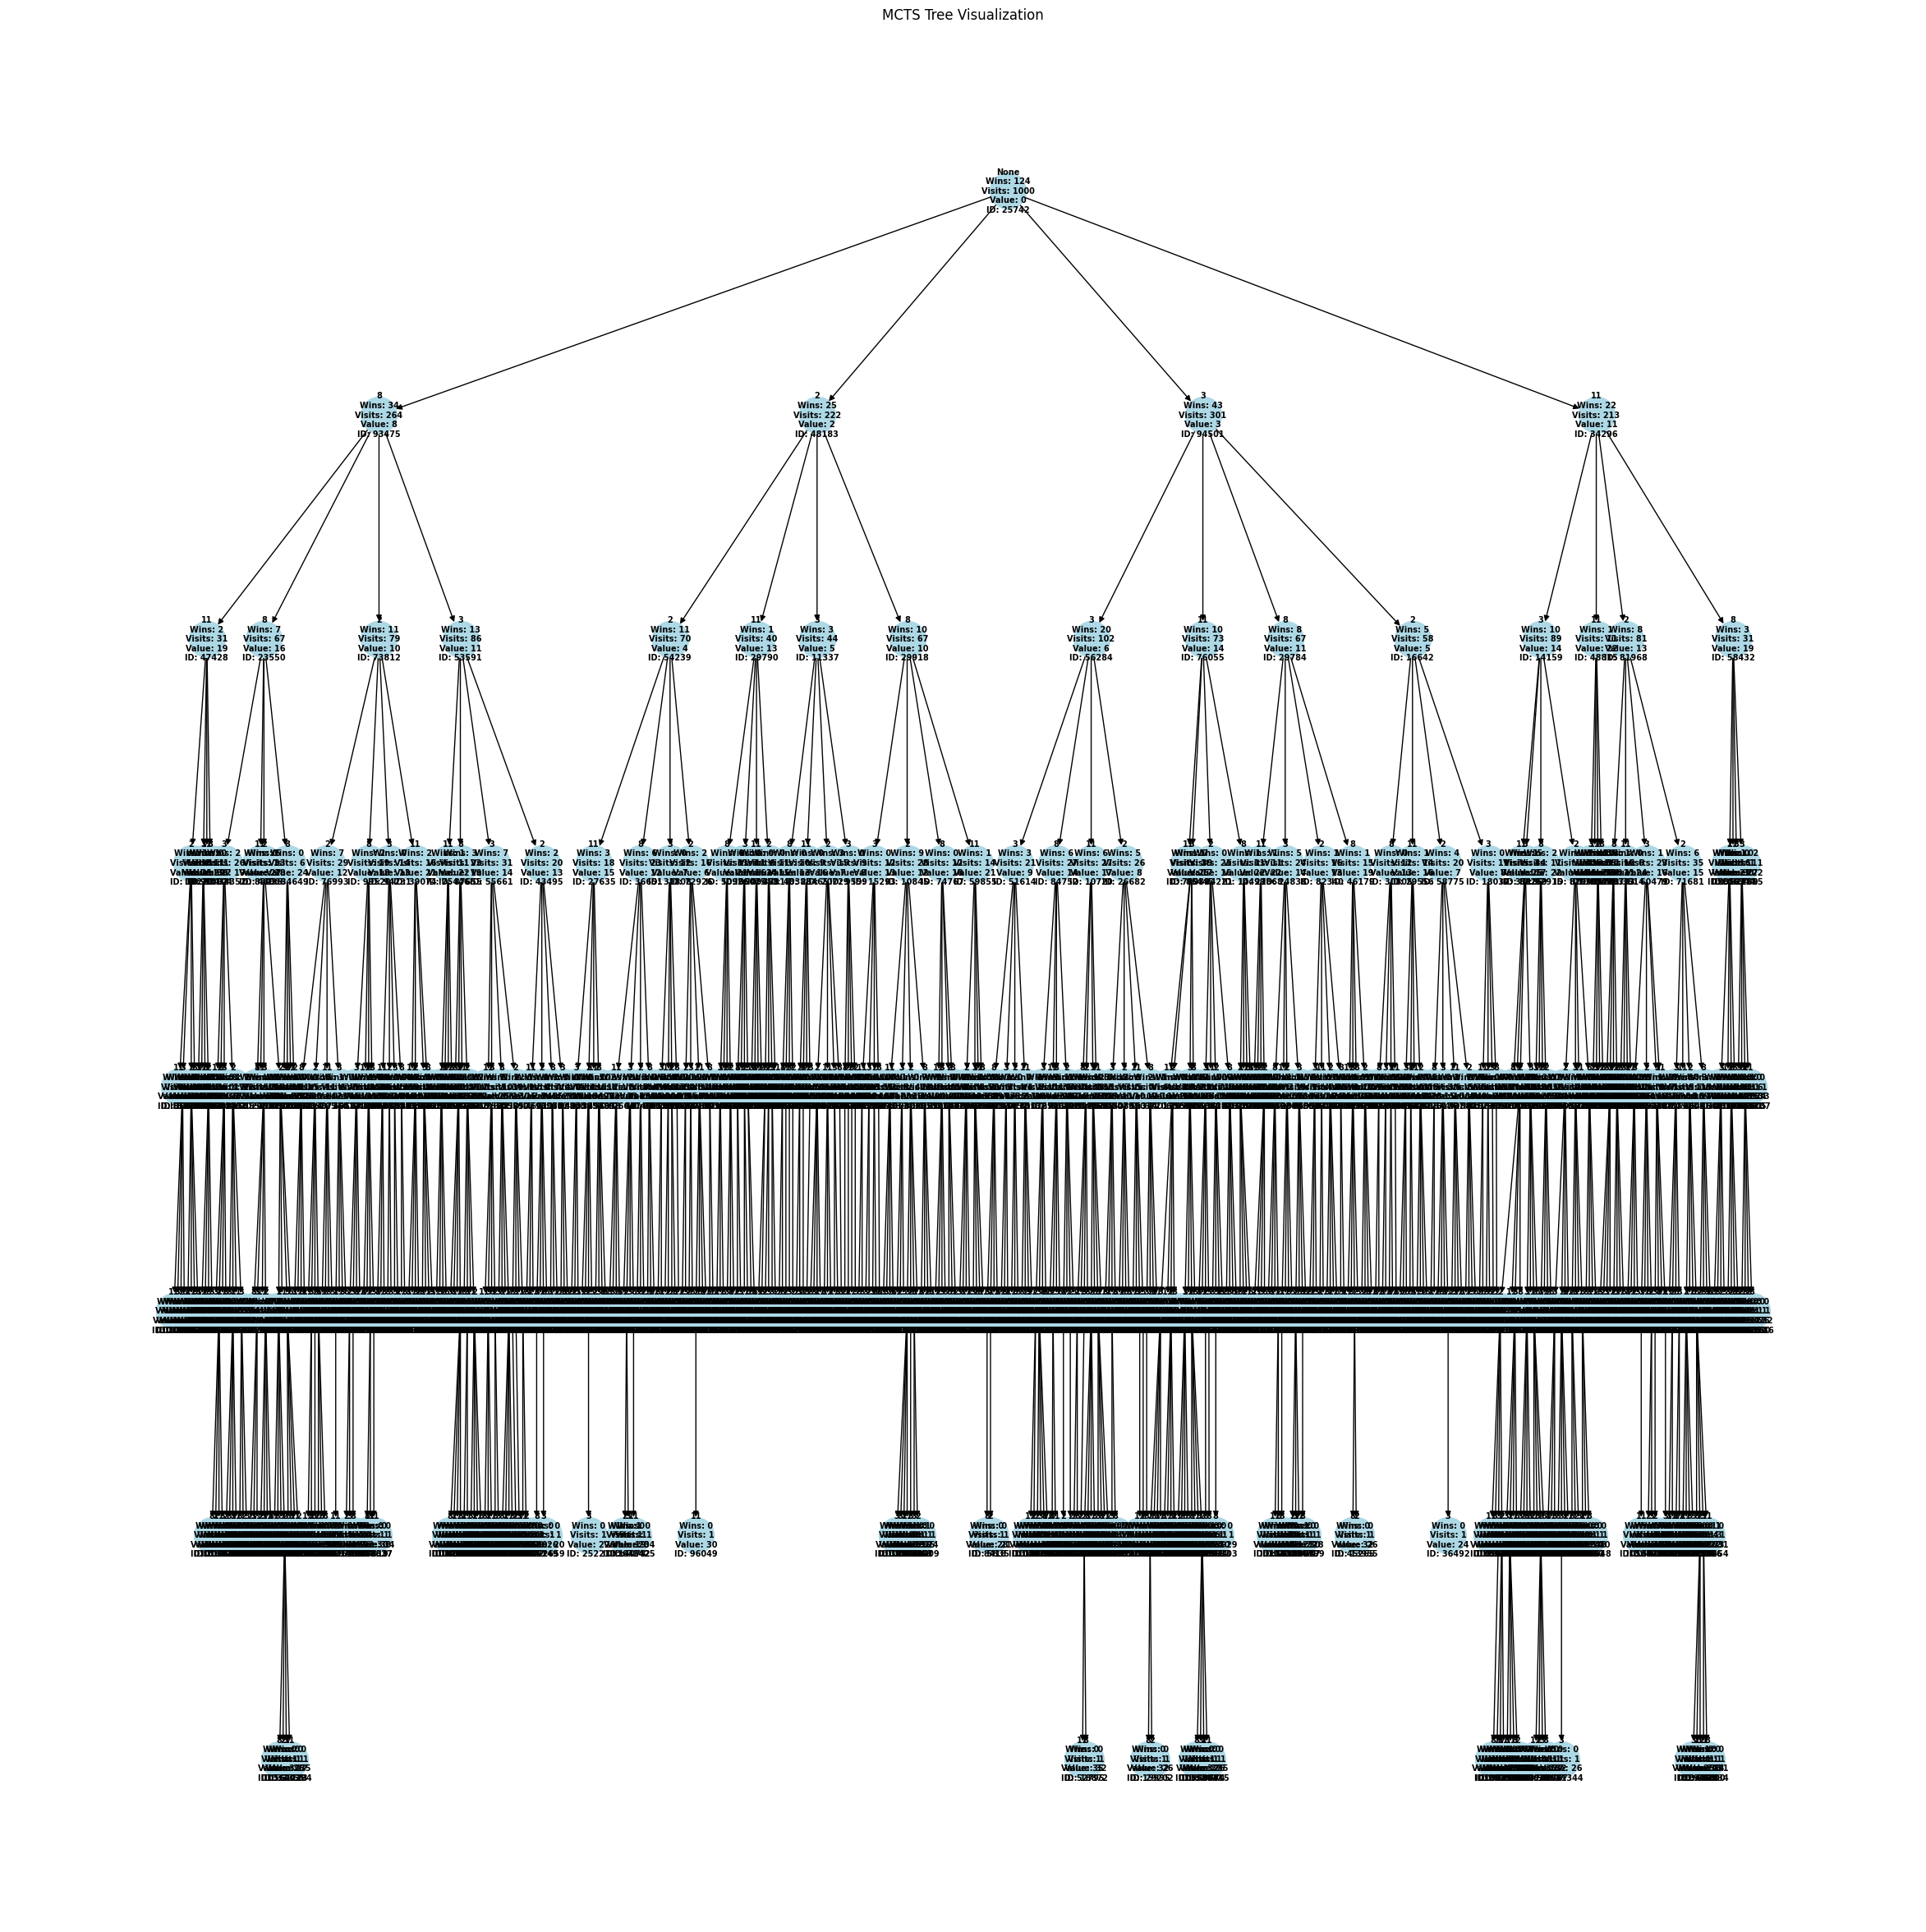

In [6]:
import matplotlib.pyplot as plt
import networkx as nx

# Example usage:
num_iter = 50
game = Game(target=25)
root = Node(state=game)
MCTS(root, iterations=1000)

def visualize_mcts_tree(root, ax=None):
    G = nx.DiGraph()
    pos = {}
    labels = {}
    for node, depth in level_order_traversal(root):
        G.add_node(node)
        pos[node] = (depth, -len([n for n in G if pos.get(n) and pos[n][0] == depth]))
        labels[node] = f"{node.move}\nWins: {node.wins}\nVisits: {node.visits}\nValue: {node.current_value}\nID: {node.node_id}"
        if node.parent:
            G.add_edge(node.parent, node)

    if ax is None:
        plt.figure(figsize=(30, 30))
        ax = plt.gca()

    # Specify the layout for better space utilization
    pos = nx.drawing.nx_agraph.graphviz_layout(G, prog='dot')

    nx.draw(G, pos, ax=ax, labels=labels, with_labels=True, arrows=True,
            node_size=1000, font_size=7, font_weight='bold', node_color='lightblue')

    plt.title('MCTS Tree Visualization')
    plt.show()

def level_order_traversal(root):
    queue = [(root, 0)]
    while queue:
        node, depth = queue.pop(0)
        yield node, depth
        for child in node.children:
            queue.append((child, depth + 1))

# Example usage
visualize_mcts_tree(root)